# Markov Chain Monte Carlo (MCMC)

GPflow allows you to approximate the posterior over the latent functions of its models (and over the hyperparameters after setting a prior for those) using Hamiltonian Monte Carlo (HMC).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.test_util import notebook_niter, is_continuous_integration
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
from multiclass_classification import plot_from_samples, colors

In this notebook, we provide three examples:
* [Sampling hyperparameters in GP regression](#example_1)
* [Sparse Variational MC for multiclass classification](#example_2)
* [Fully Bayesian inference for generalised GP models with HMC](#example_3)

<a id='example_1'></a>
## Sampling hyperparameters in GP regression

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

The GPR model parameterised by $\theta = [\tau]$ is given by
$$ Y_i = f(X_i) + \varepsilon_i$$
where $f \sim \mathcal{GP}(\mu(.), k(., .))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

See [Basic (Gaussian likelihood) GP regression model](../basics/regression.ipynb) for more details on GPR and for a treatment of the direct likelihood maximisation.



### Data for a one-dimensional regression problem

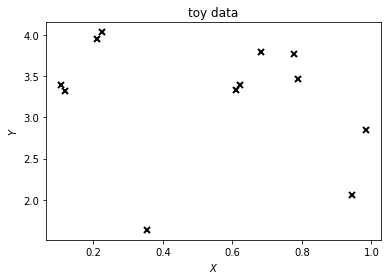

In [2]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('toy data')
plt.show()

### MCMC for hyperparameters $\theta$

We now want to sample from the posterior over $\theta$: 
$$p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)$$

Firstly, we build the GPR model:

In [ ]:
gpflow.reset_default_graph_and_session()
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

Secondly, we initialise the model to the maximum likelihood solution:

In [4]:
gpflow.train.ScipyOptimizer().minimize(m)
print('log likelihood at optimum:', m.compute_log_likelihood())

log likelihood at optimum: -7.156391632101176


Thirdly, we add priors to the hyperparameters:

In [5]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.07516823547983985
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.7246867030866287
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.0002129434406357e-06
GPR/mean_function/A,Parameter,"N(0.0,10.0)",(none),True,"(1, 1)",True,[[-0.45633325786889056]]
GPR/mean_function/b,Parameter,"N(0.0,10.0)",(none),True,(),True,3.2948353412032207


We now sample from the posterior using HMC:

In [6]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=gpflow.test_util.notebook_niter(500),
                         epsilon=0.05, lmin=10, lmax=20, logprobs=False)

Next we display the sampled hyperparameters:

Text(0, 0.5, 'parameter value')

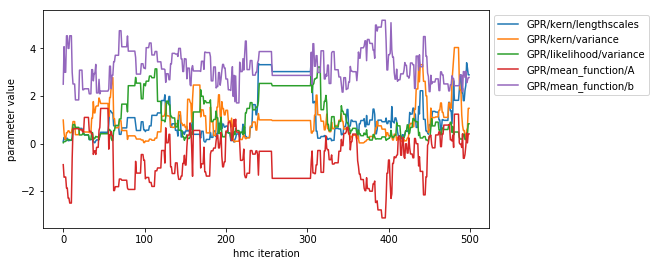

In [7]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

You can also inspect the marginal distribution of samples:

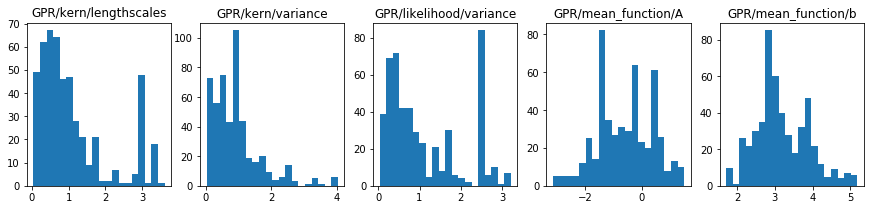

In [8]:
hyperparameters = ['GPR/kern/lengthscales', 
                   'GPR/kern/variance', 
                   'GPR/likelihood/variance', 
                   'GPR/mean_function/A', 
                   'GPR/mean_function/b']

fig, axarr = plt.subplots(1, len(hyperparameters), figsize=(15,3))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(np.stack(samples[hyp]).reshape(-1,1),bins=20)
    ax.set_title(hyp);#
plt.show()



**NOTE:** The sampler runs in unconstrained space (so that positive parameters remain positive, and parameters that are not trainable are ignored).
However, GPflow returns a dataframe with values in the true units.

This notebook is for illustrative purposes only; for serious analysis you would most certainly want to run the sampler for longer, with multiple chains and convergence checks. 


Text(0, 0.5, 'signal_variance')

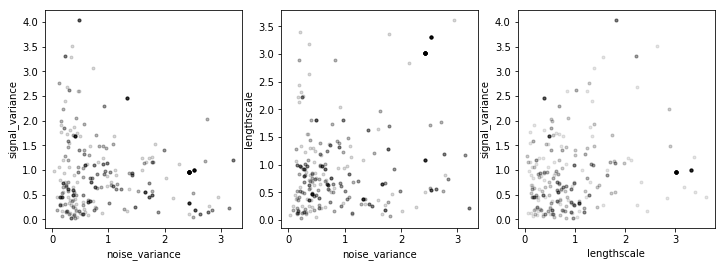

In [9]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples['GPR/kern/lengthscales'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (the set of hyperparameters) we'll draw some samples from the prediction function.

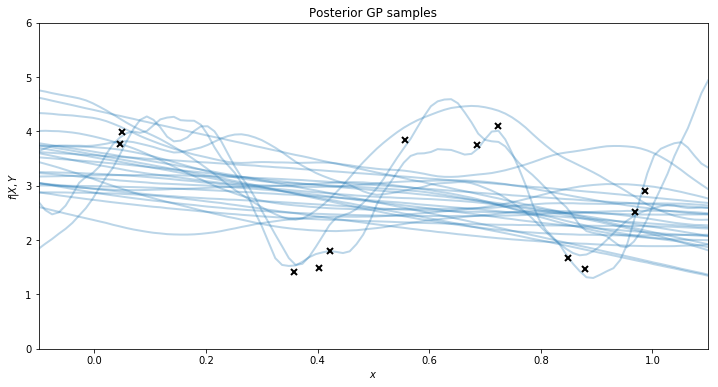

In [10]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.3)
    
plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel('$x$')
plt.ylabel('$f|X,Y$')
plt.title('Posterior GP samples')

plt.show()

<a id='example_2'></a>
## Sparse Variational MC for multiclass classification

We now consider the [multiclass classification](../advanced/multiclass_classification.ipynb) problem. Here the marginal likelihood is not available in closed form. Instead we use a sparse variational approximation where we approximate the posterior for each GP as $q(f_c) \propto p(f_c|\mathbf{u}_c)q(\mathbf{u}_c)$

In the standard Sparse Variational Gaussian Process (SVGP) formulation, $q(\mathbf{u_c})$ is parameterised as a multivariate Gaussian.

An alternative is to directly sample from the optimal $q(\mathbf{u}_c)$; this is what sparse variational GP using MCMC (SGPMC) does. 

In [11]:
gpflow.reset_default_graph_and_session()
from gpflow.test_util import notebook_niter, is_continuous_integration

We first build a multiclass classification dataset:

In [12]:
# Number of functions and number of data points
C, N = 3, 100
# Input
X = np.random.rand(N, 1)
# RBF kernel matrix
kern = gpflow.kernels.RBF(1, lengthscales=0.1)
K = kern.compute_K_symm(X) + np.eye(N) * 1e-6
# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)
# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

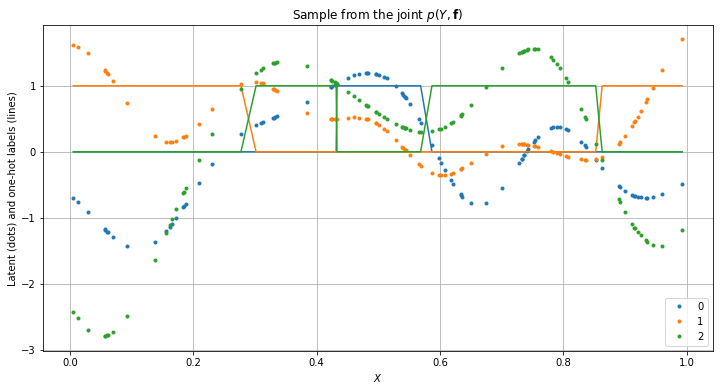

In [13]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])

plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

We then build the SGPMC model:

In [14]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y, 
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(2., 2.)
    m.kern.kernels[1].variance.trainable = False
    
m.compile()

The chain of samples for $\mathbf{u}_c, \theta$ is initialised at the value maximising  $p(Y|\mathbf{u}_c, \theta)$:

In [ ]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=notebook_niter(10))

Sampling starts with a 'burn in' period:

In [16]:
ci = is_continuous_integration()
burn = 0 if ci else 100
thin = 1 if ci else 10

In [17]:
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=notebook_niter(500), 
                     epsilon=0.04, lmax=15, logprobs=False)

Statistics of the posterior samples can now be reported:

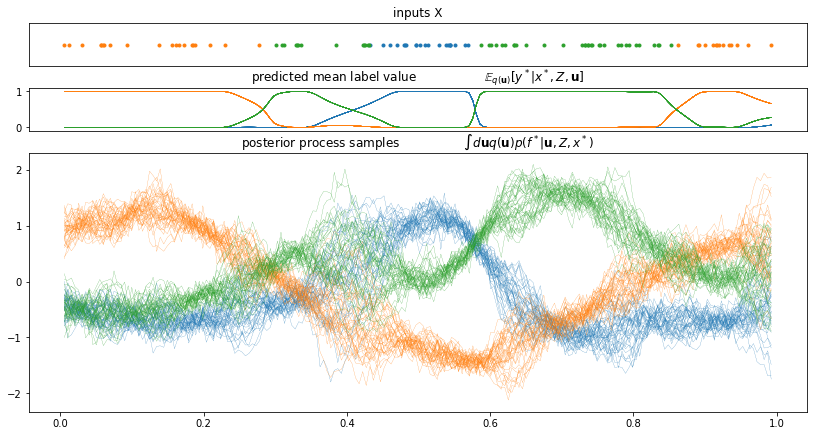

In [18]:
plot_from_samples(m, samples, burn, thin)

You can also display the sequence of sampled hyperparameters:

Text(0, 0.5, 'hyper-parameter value')

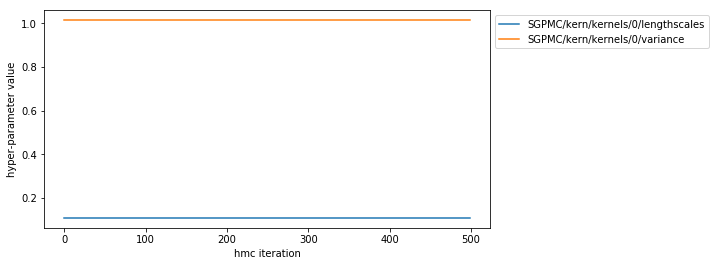

In [19]:
hyperparameters = ['SGPMC/kern/kernels/0/lengthscales',
                   'SGPMC/kern/kernels/0/variance']

plt.figure(figsize=(8,4))
for i, col in samples[hyperparameters].iteritems():
    plt.plot(col, label=col.name)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value')

<a id='example_3'></a>
## Fully Bayesian inference for generalised GP models with HMC

You can construct very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the Generalised Linear Model literature). This makes inference of the GP intractable because the likelihoods are not generally conjugate to the Gaussian process. The general form of the model is: 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC over the function values and the parameters $\theta$ jointly, using Hamiltonian Monte Carlo (HMC). The key to an effective scheme is rotation of the field using the Cholesky decomposition. We write:

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over $v$ and the function values is not widely adopted in the literature because of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in TensorFlow, and so application of HMC is relatively straightforward. 

### Exponential Regression
We consider an exponential regression model: 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. First, generate a dataset:

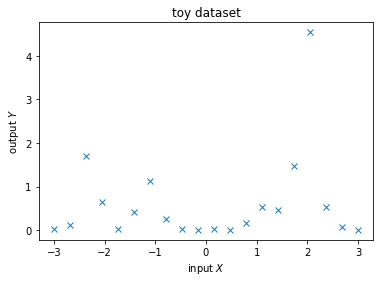

In [20]:
X = np.linspace(-3,3,20)
Y = np.random.exponential(np.sin(X)**2)

plt.figure()
plt.plot(X,Y,'x')
plt.xlabel('input $X$')
plt.ylabel('output $Y$')
plt.title('toy dataset')
plt.show()

GPflow's model for fully Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [21]:
gpflow.reset_default_graph_and_session()

with gpflow.defer_build():
    k = gpflow.kernels.Matern32(1, ARD=False) + gpflow.kernels.Bias(1)
    l = gpflow.likelihoods.Exponential()
    m = gpflow.models.GPMC(X[:,None], Y[:,None], k, l)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are arbitrary, for illustration). 

In [22]:
m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[1].variance.prior = gpflow.priors.Gamma(1., 1.)

Running HMC is pretty similar to optimising a model. GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation; for example, No U-Turn Sampler (NUTS) is not implemented.

There are two things to tune, the step size (epsilon) and the number of steps $[L_{min}, L_{max}]$. Each proposal takes a random number of steps between $L_{min}$ and $L_{max}$, each of length $\epsilon$. 

We initialise HMC at the maximum a posteriori (MAP) parameter value.

In [23]:
m.compile()
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m, maxiter=notebook_niter(15)) # start near maximum a posteriori (MAP)

We then run the sampler:

In [24]:
s = gpflow.train.HMC()
samples = s.sample(m, notebook_niter(500),
                   epsilon=0.12, lmax=20, lmin=5, thin=5, logprobs=False)#, verbose=True)

Then we compute the posterior prediction on a grid for plotting purposes:

In [25]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []
for i, s in samples.iterrows():
    f = m.predict_f_samples(xtest, 5, initialize=False, feed_dict=m.sample_feed_dict(s))
    f_samples.append(f)
f_samples = np.vstack(f_samples)

(-0.1, 5.791237916968663)

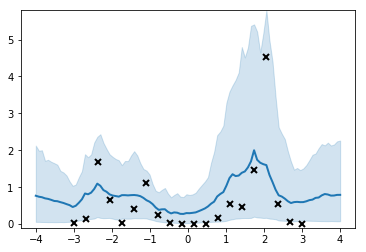

In [26]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

You can also display the sequence of sampled hyperparameters:

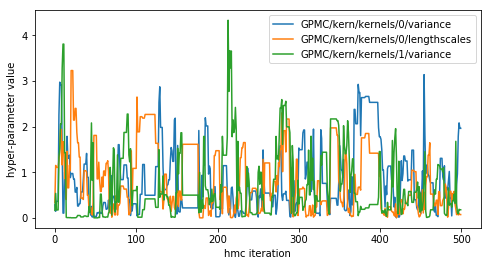

In [27]:
hyperparameters = ['GPMC/kern/kernels/0/variance',
                   'GPMC/kern/kernels/0/lengthscales',
                   'GPMC/kern/kernels/1/variance']

plt.figure(figsize=(8,4))
for i, col in samples[hyperparameters].iteritems():
    plt.plot(col, label=col.name)
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('hyper-parameter value')
plt.show()

You can also inspect the marginal of the posterior samples:

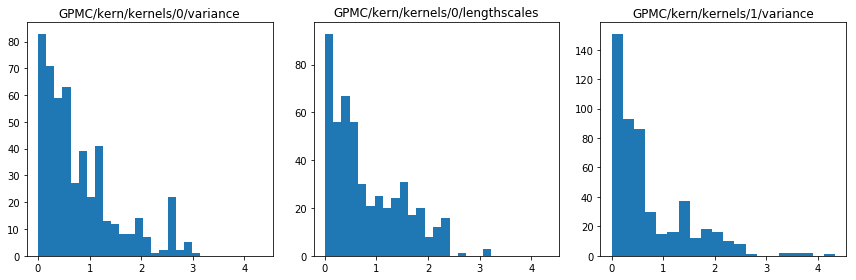

In [28]:
fig, axarr = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12,4))
for i, hyp in enumerate(hyperparameters):
    ax = axarr[i]
    ax.hist(samples[hyp],bins=20)
    ax.set_title(hyp);
plt.tight_layout()